# Intended to replace load_and_process

In [29]:
import pandas as pd
import numpy as np
import sqlite3
import json

import sys
sys.path.append("D:\\projects\\geo_image_experiments\\src")
import importlib
import mapillary_utils as mu
importlib.reload(mu)
from dotenv import load_dotenv
from os import getenv

from PIL import Image


from matplotlib.path import Path

import matplotlib.pyplot as plt

In [12]:
load_dotenv()
API_KEY = getenv("MAPILLARY_CLIENT_TOKEN")
api_key = API_KEY

image_id = '1068419173817547'
image_path = f"c:\\temp\\mapillary_{image_id}.jpg"
image_path


'c:\\temp\\mapillary_1068419173817547.jpg'

In [30]:
image, metadata = mu.get_mapillary_image(image_id, api_key, image_size_indicator='thumb_2048_url', image_dir="c:\\temp")

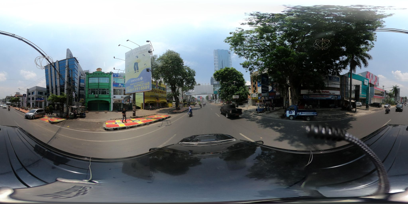

In [31]:
# show a small version of the image
small_image = image.copy()
small_h = int(image.size[0] / 5)
small_w = int(image.size[1] / 5)
size = (small_h, small_w)
small_image.thumbnail(size)
small_image

In [32]:
metadata

{'guid': '438b8449c55a48ccaf3b91fe1e34cbcb',
 'image_source': 'mapillary',
 'image_id': '1068419173817547',
 'captured_at_unix': 1663759562000,
 'lat': -5.4154514,
 'lon': 105.2583156,
 'original_height': 2880,
 'original_width': 5760,
 'height': 1024,
 'width': 2048,
 'camera_type': 'spherical',
 'sequence': 'HzT543QSh0ojXdUwsmEIcO',
 'compass_angle': 180.06888889121,
 'computed_compass_angle': 180.56661679528,
 'is_pano': True,
 'camera_focal_len': None,
 'camera_k1': None,
 'camera_k2': None,
 'altitude': 117.692,
 'image_path_on_disk': 'c:\\temp//mapillary_1068419173817547_thumb_2048_url.jpg'}

In [17]:
detections = mu.get_mapillary_detections(image_id, api_key)

In [19]:
df_detections = mu.extract_detections(detections)

In [53]:
arrays = df_detections.apply(lambda x: mu.decode_base64_geometry_fromdf(x, normalize=True, image_height=metadata['height'],\
                                                                                         image_width=metadata['width']), axis=1)

temp_df = [pd.DataFrame(arr, columns=['image_id', 'detection_id','detection_label','feature_id', 'image_height', 'image_width', 'extent','properties','coordinates']) for arr in arrays]
df_detection_coords = pd.concat(temp_df, ignore_index=True)

In [54]:
df_detection_coords.sample()

image_id      detection_id     detection_label feature_id  \
348  1068419173817547  1068631470462984  nature--vegetation          1   

    image_height image_width extent properties  \
348         1024        2048   4096         {}   

                                           coordinates  
348  [[27, 515], [27, 514], [21, 512], [19, 509], [...

In [105]:
def draw_polygons(polygons,  max_x=2200, max_y=1200, display='fill', image_underlay=None, color='green'):
    """
    Draws polygons on top of a background image.

    Parameters:
    - polygons: List of polygons to draw (list of (x, y) coordinates).
    - image_path: Path to the background image.
    - max_x: Maximum x-axis size.
    - max_y: Maximum y-axis size.
    - display: 'fill' or 'outline' to specify whether to fill or outline polygons.
    - color: Color for the polygon.

    Returns:
    - normalized_polygon: Normalized polygons (currently not used).
    """
    normalized_polygon = []
    polygons_for_chart = []
    
    for polygon in polygons:
        w = []
        y = []
        for xy in polygon:

            w.append(xy[0])
            y.append(xy[1])
        polygons_for_chart.append([w,y])


    #set x figsize, then proportionately set y
    fig_x = 8
    fig_y = int(max_y / (max_x / fig_x))
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))  

    if image_underlay != None:
        ax.imshow(image_underlay, extent=[0, max_x, 0, max_y], aspect='auto')
    
    for shape in polygons_for_chart:
        if display == 'outline':
            ax.plot(shape[0], shape[1], marker='', markersize=1, color=color)
        elif display == 'fill':
            ax.fill(shape[0], shape[1], color=color)     
        else:
            ax.fill(shape[0], shape[1], color=color)

    #ax.plot(w, y, marker='o', markersize=2) 
    #ax.plot([10,100,100,10], [100,100,10,10], marker='o', markersize=2) 

    # Set the x and y limits to be consistent
    #max_value = 3000  # Example maximum value
    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)
    
    # Force the two axes to intersect at 0
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    # Adding title and labels
    plt.title('Path Plot of w and y Coordinates')
    plt.xlabel('w')
    plt.ylabel('y')
    
    # Display the plot
    plt.show()

    return normalized_polygon

In [81]:
set(df_detection_coords.detection_label.tolist())


{'construction--barrier--curb',
 'construction--flat--driveway',
 'construction--flat--road',
 'construction--flat--traffic-island',
 'construction--structure--bridge',
 'construction--structure--building',
 'human--person--individual',
 'human--rider--motorcyclist',
 'marking--continuous--solid',
 'nature--sky',
 'nature--vegetation',
 'object--banner',
 'object--sign--advertisement',
 'object--sign--back',
 'object--sign--store',
 'object--street-light',
 'object--support--pole',
 'object--support--utility-pole',
 'object--traffic-sign--back',
 'object--traffic-sign--direction-front',
 'object--vehicle--bus',
 'object--vehicle--car',
 'object--vehicle--motorcycle',
 'object--vehicle--other-vehicle',
 'object--wire-group',
 'void--dynamic',
 'void--ego-vehicle',
 'void--ground',
 'void--static',
 'void--unlabeled'}

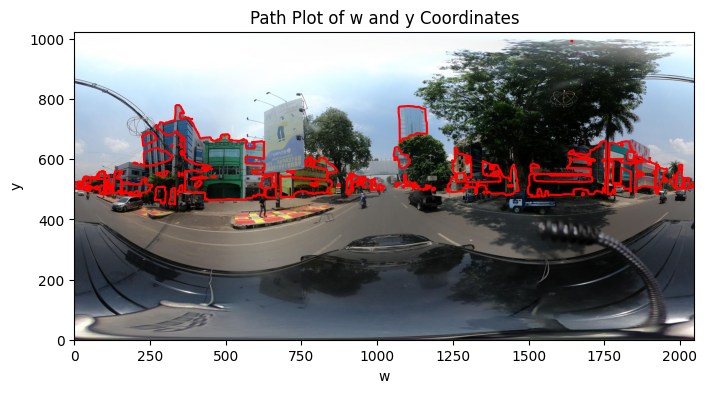

[]

In [107]:
selected_label = 'construction--structure--building'
draw_polygons(df_detection_coords[df_detection_coords.detection_label == selected_label].coordinates.tolist(), max_x=image.size[0], max_y=image.size[1], display='outline', image_underlay=image, color='red')

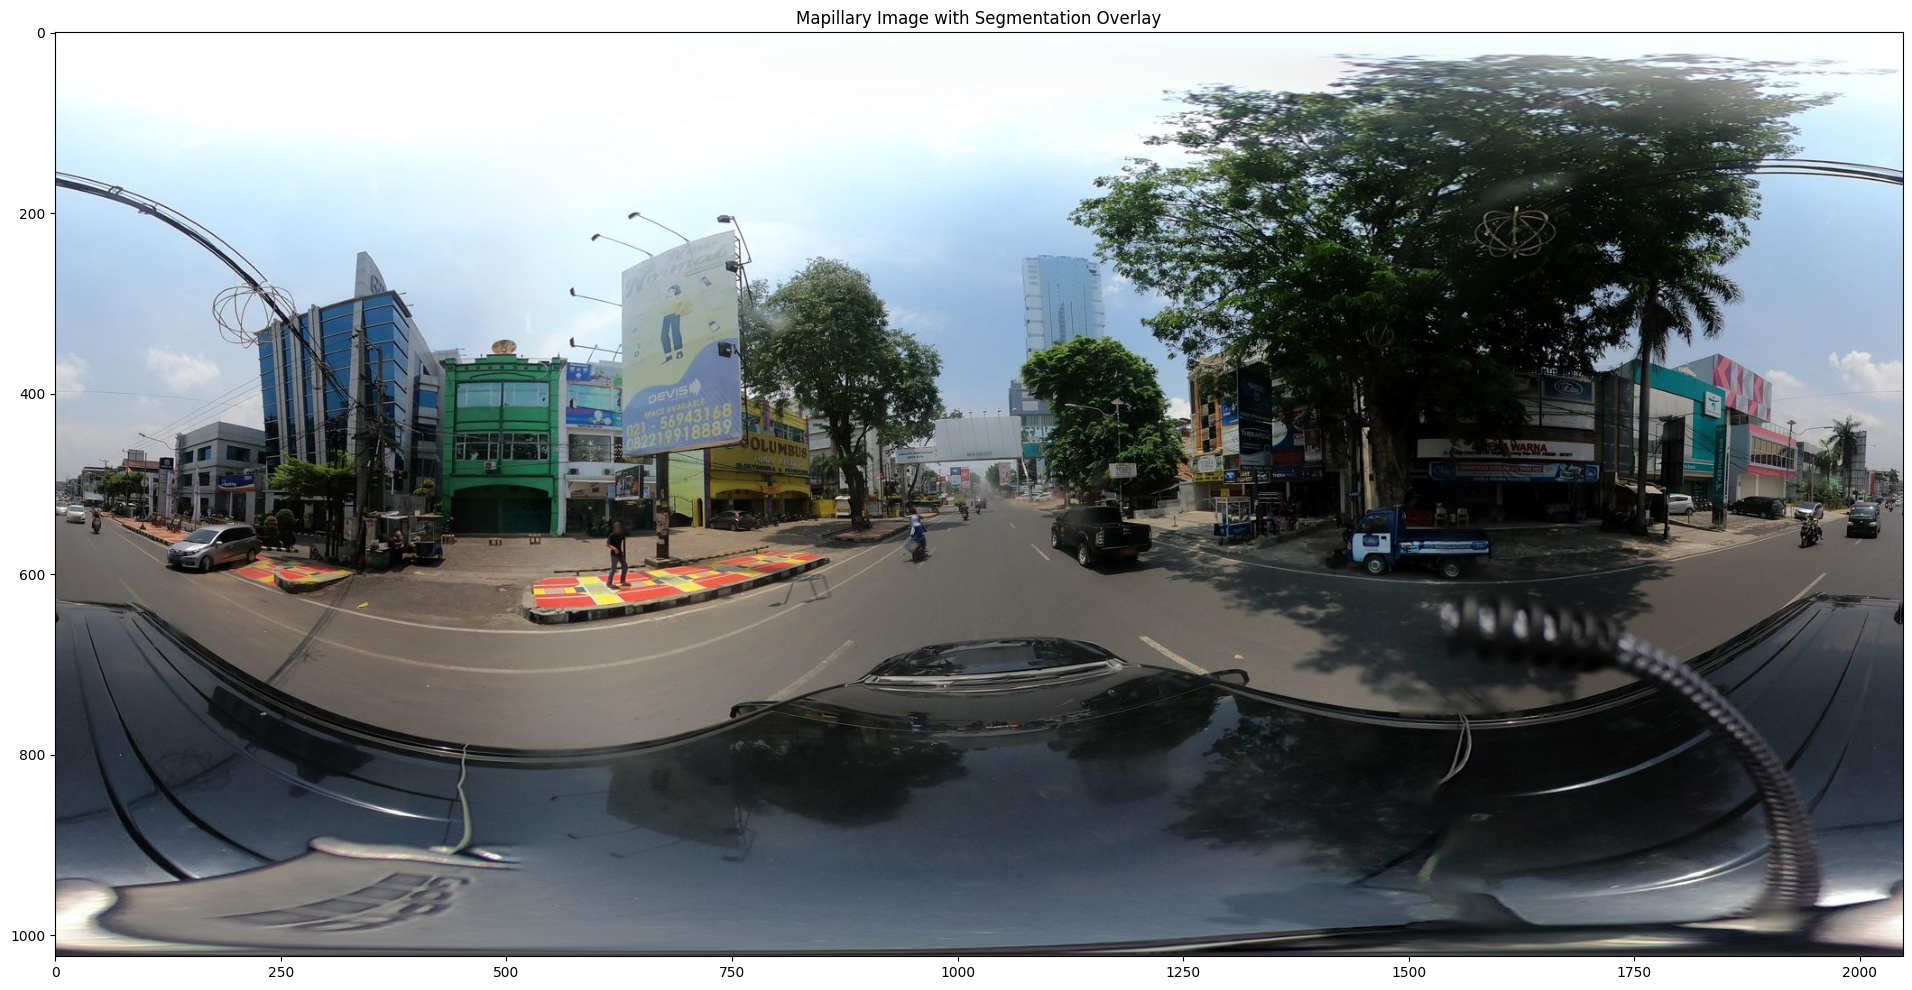

In [90]:
masked_image = np.array(image)
#masked_image[mask == 1] = [255, 0, 0]  # Color roads in red
#masked_image[mask == 2] = [0, 0, 255]  # Color buildings in blue

# Step 5: Visualize the result
plt.figure(figsize=(24, 12))
plt.imshow(masked_image)
plt.title('Mapillary Image with Segmentation Overlay')
plt.show()


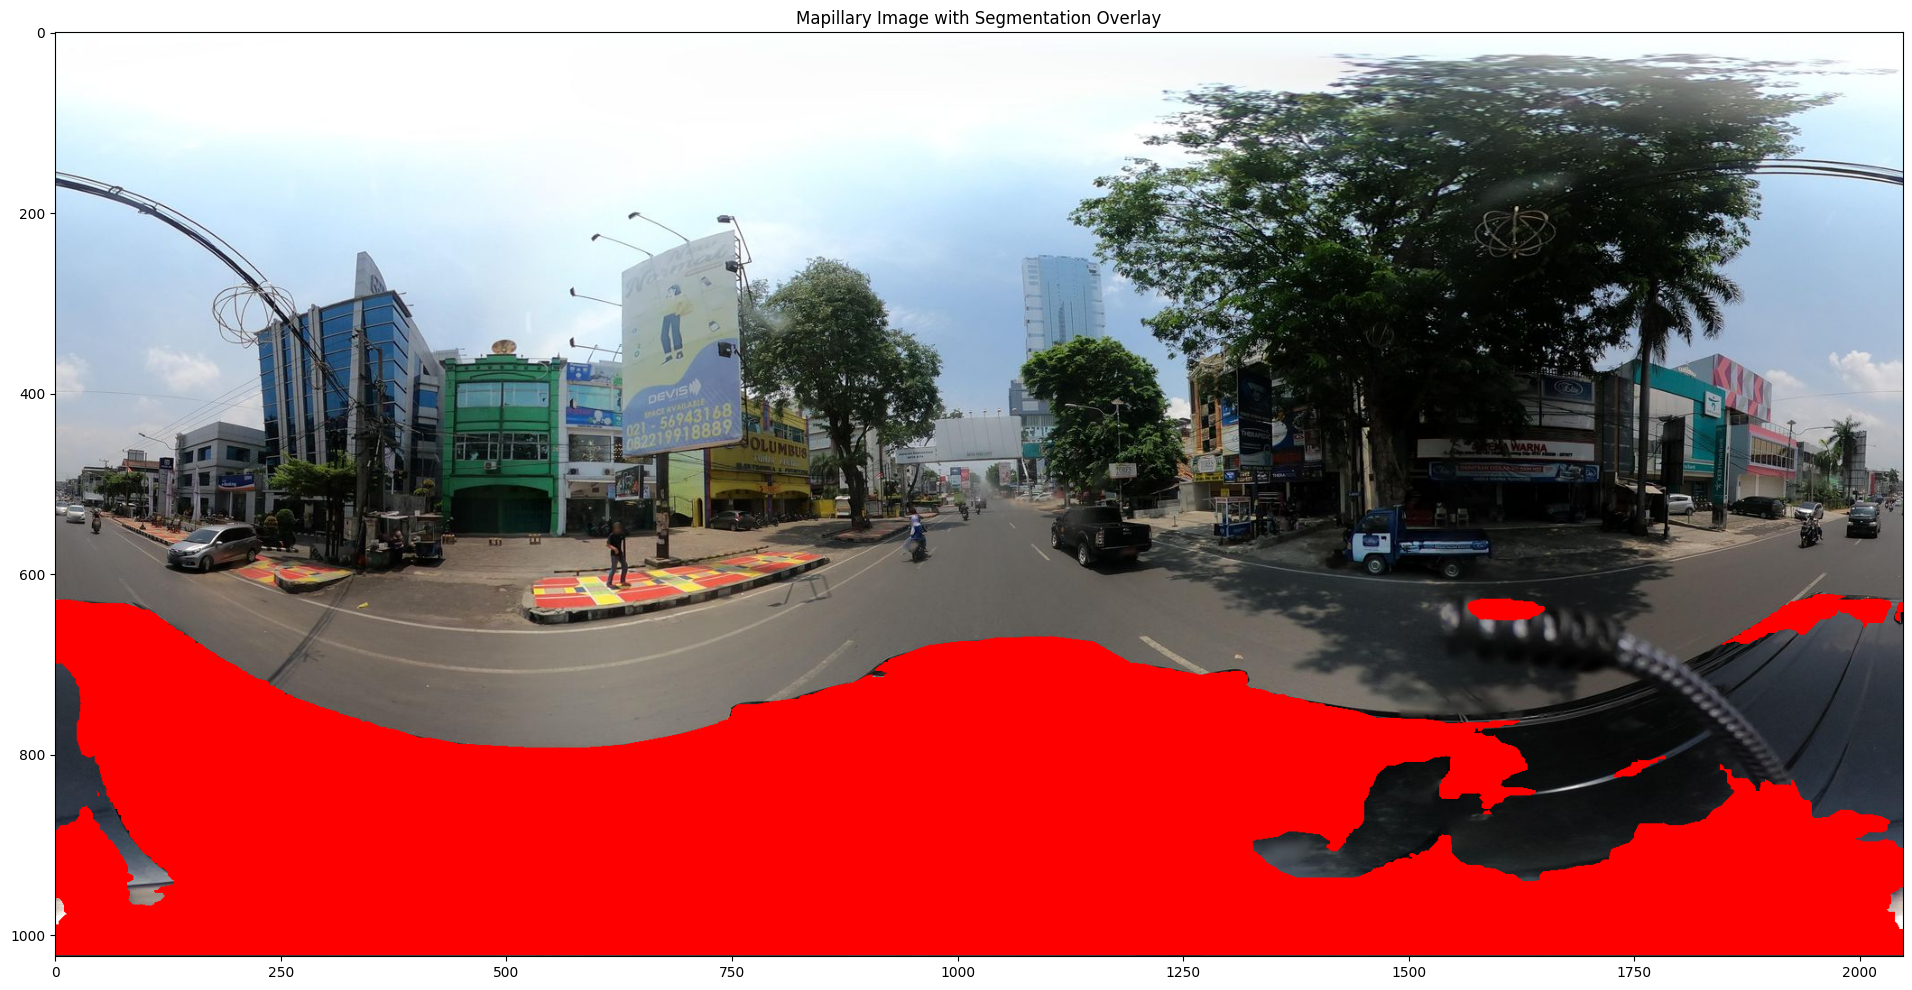

In [88]:
# Initialize an empty mask
mask = np.zeros((image.height, image.width), dtype=np.uint8)

def create_mask(mask, polygon, value):
    y, x = np.mgrid[:mask.shape[0], :mask.shape[1]]
    points = np.vstack((x.ravel(), y.ravel())).T
    path = Path(polygon)
    mask[path.contains_points(points).reshape(mask.shape)] = value

def create_mask_from_multiple_coords(mask, polygons, value):
    for polygon in polygons:
        y, x = np.mgrid[:mask.shape[0], :mask.shape[1]]
        points = np.vstack((x.ravel(), y.ravel())).T
        path = Path(polygon)
        mask[path.contains_points(points).reshape(mask.shape)] = value


#x_poly = [[100,100],[500,100],[500,500],[100,500]]
#draw_polygons(mask, normalized_polygon, 1)
create_mask_from_multiple_coords(mask, df_detection_coords['coordinates'][df_detection_coords.detection_label == 'void--ego-vehicle'].tolist(), 1)

#reverse the mask on the horizontal dimension
mask = mask[::-1]


# Step 4: Overlay the mask on the image
masked_image = np.array(image)
masked_image[mask == 1] = [255, 0, 0]  # Color roads in red
masked_image[mask == 2] = [0, 0, 255]  # Color buildings in blue

# Step 5: Visualize the result
plt.figure(figsize=(24, 12))
plt.imshow(masked_image)
plt.title('Mapillary Image with Segmentation Overlay')
plt.show()